## _Training: DNN Tracking on STT (Hit Pairs)_

Waleed's TrackML like solution. Its similar to TrackML second solution (difference is in feature columns, prob table, hits in adjacent layers).

- Dense Neural Network (DNN)
- Hit Pair Probability Table
- Cluster Hits into Tracks

Inputs (features) and Targets (Labels) for this method are;

$$X = (h_{i}, h_{j})$$
$$y = 1 / 0$$

Where $h_{i}$ = __*(hit_id, x, y, skewed, layer_id, sector_id, isochrone_radius, particle_id)*__ etc. We can add more information in a hit.

Note
- Train[:,:-1] all columns except last one (-1), Train[:,-1] only last column (-1)

### _For validation accuracy $\ge$ training accuracy_

- [stackoverflow.com](https://stackoverflow.com/questions/43979449/higher-validation-accuracy-than-training-accurracy-using-tensorflow-and-keras)
- [keras.io](https://keras.io/getting-started/faq/#why-is-the-training-loss-much-higher-than-the-testing-loss)
- [cs231n.github.io](http://cs231n.github.io/neural-networks-3/#sanitycheck)

### _Network Performance_

- We would expect many more epochs needed to minimize the error or we may just have too many hidden nodes.
- If an epoch consists of $11 \times 10^6$ examples, then most of the update work might already be done within the $1^{st}$ epoch. In that case, a **loss graph** over **training example number** rather than over epochs might be more instructive to see initial training behaviour.
- Did you use [early stopping](https://machinelearningmastery.com/early-stopping-to-avoid-overtraining-neural-network-models/) to avoid overtraining? **Issue:** it might not use whole data set. **Solution:** use epoch number as hyeprparameter.
- Hyperparameter Tuning (**GridSearchCV**)
- Maybe some data preprocessing might help the network to ease the task of implicit data preprocessing. In other words, you might want to apply a standardizing [(log-)z-score transformation](https://en.wikipedia.org/wiki/Standard_score) before training.

In [1]:
import os
import glob
import math
import random

In [2]:
import pickle
import numpy as np
import pandas as pd
import dask.dataframe as dd
from tqdm import tnrange
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [3]:
from init_models import init_model, init_model_dnn
from utils import dask_events, load_events, preprocess, prepare_train_set, prepare_test_set
from drawing import draw_train_history, draw_pickled_history, draw_single_event, draw_reco_event

Using TensorFlow backend.


In [4]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [5]:
# import keras as k
# import tensorflow as tf
# print("tensorflow:", tf.__version__, ", tf.keras:", tf.keras.__version__, ", keras:", k.__version__)

In [6]:
def plot_single_event(event=None, event_id=9999, name="event"):
    p_ids = np.unique(event.particle_id.values)
    det = pd.read_csv("stt.csv")
    # plt.style.use('seaborn')
    fig = plt.gcf()
    plt.figure(figsize=(10,10))
    skw = det.query('skewed==0')
    nkw = det.query('skewed==1')
    plt.scatter(skw.x.values, skw.y.values, s=30, facecolors='none', edgecolors='lightgreen')
    plt.scatter(nkw.x.values, nkw.y.values, s=30, facecolors='none', edgecolors='coral')
    for i in p_ids:
        df_ = event.loc[event.particle_id==i]
        plt.scatter(df_.x.values, df_.y.values, s=30, label='particle_id: %d'%i)
    plt.title('Event # %d'%event_id)
    plt.xlabel('x [cm]', fontsize=10)
    plt.ylabel('y [cm]', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlim((-41,41))
    plt.ylim((-41,41))
    #plt.axis('scaled')
    plt.grid(False)
    plt.legend(fontsize=10, loc='best')
    # plt.savefig(name+'_%d.png'%event_id)
    plt.show()
    # return fig

## _Params/Configs_

In [7]:
batch_size=256
epochs=10
val_frac=0.1

In [8]:
# path = os.environ['HOME']+'/current/data_sets/'+'mljuelich/data2/'
path = os.environ['HOME']+'/current/2_deepana/pandaml/data/'

In [22]:
if not os.path.exists(os.environ['HOME']+'/current/2_deepana/pandaml/models'):
    os.mkdir('models')

## _Load Events_

In [10]:
# load single event using event_prefix
def get_event(path, event_prefix):
    hits= pd.read_csv(path+'%s-hits.csv'%event_prefix)
    tubes= pd.read_csv(path+'%s-tubes.csv'%event_prefix)
    truth= pd.read_csv(path+'%s-truth.csv'%event_prefix)
    particles= pd.read_csv(path+'%s-particles.csv'%event_prefix)
    
    return hits, tubes, truth, particles

## _Event Vizualization_

In [11]:
event_id = 1
event_prefix = 'event00000000%02d'%event_id

In [12]:
hits, tubes, truth, particles = get_event(path, event_prefix)

In [13]:
hits.particle_id.unique()

array([10,  9,  8,  7,  6,  5,  4,  2,  1])

<Figure size 432x288 with 0 Axes>

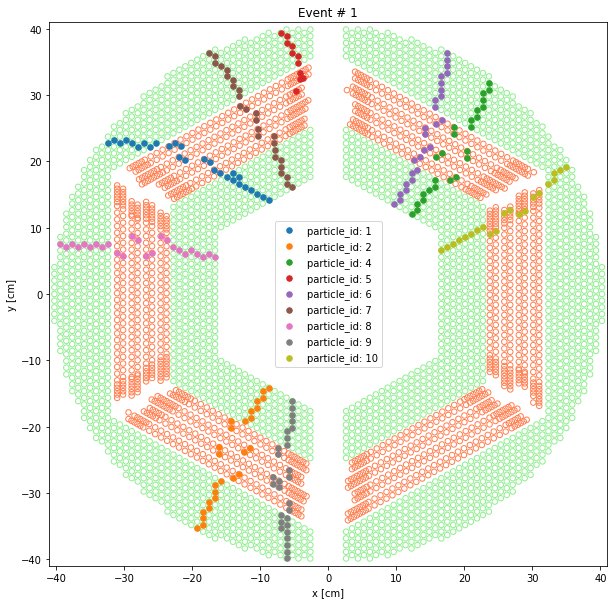

In [14]:
plot_single_event(hits, event_id)

## _Preprocessing_

In [ ]:
# hits.head()

In [ ]:
# hits.index

In [ ]:
# hits.hit_id

In [ ]:
# tubes.head()

In [ ]:
# truth.head()

In [ ]:
# particles.head()

In [ ]:
# hits = hits.drop(['volume_id','depcharge','particle_id'], axis=1)

# df = event[['skewed', 'layer_id']]   # select only 2 columns
# df = df[df['skewed'] == 0]           # all non skewed
# df = df.query('skewed==0')
# df = df[df['skewed'] == 1]           # all skewed, layers = 8,9,2,...15 are skewed
# df = df.query('skewed==1')

# df = df[df['layer_id'] < 8]          # layers = 0,1,2,...7 are before skewed
# df = df[df['layer_id'] > 15]         # layers = 16,17,...24 are after skewed
# df = df[(df['layer_id'] > 7) & 
# (df['layer_id'] < 16)]               # layers = 8,9,2,...15 are skewed

# df.cluster_id.unique()
# df.layer.unique()
# df[df["layer"] < 3].head()
# df[(df["layer"] < 5) & (df["layer"] > 3)].head()
# df.loc[df["layer"].isin([2, 3])].head()
# df.loc[~df["layer"].isin([2, 3])].head()
# df.loc[(df["cluster_id"]==8) & df["layer"].isin([2, 3])].head()

## _Prepare Training Data_

Dataset for training (Hit Doublets)

In [15]:
train = True

In [16]:
# you can jump to step4 for test only.
if train:
    Train = []
    for i in tqdm_notebook(range(0, 10)):
        event_prefix = 'event00000000%02d'%i
        hits, tubes, truth, particles = get_event(path, event_prefix)
        
        # preprocessing tasks
        # hits = hits.drop(['volume_id','depcharge','particle_id'], axis=1)
        
        # create features=[x,y,z, ]
        features = np.hstack((hits[['x','y','z']],
                              # hits[['tube_id']]/1000,
                              # hits[['skewed','layer_id','sector_id']]/10,
                              hits[['isochrone', 'energyloss']]))
        
        particle_ids = truth.particle_id.unique()
        particle_ids = particle_ids[np.where(particle_ids!=0)[0]]
        pair = []
        for particle_id in particle_ids:
            hit_ids = truth[truth.particle_id == particle_id].hit_id.values-1
            for i in hit_ids:
                for j in hit_ids:
                    if i != j:
                        pair.append([i,j])
                        
        pair = np.array(pair)
        
        Train1 = np.hstack((features[pair[:,0]], features[pair[:,1]], np.ones((len(pair),1))))
        
        if len(Train) == 0:
            Train = Train1
        else:
            Train = np.vstack((Train,Train1))

        n = len(hits)
        size = len(Train1)*3
        p_id = truth.particle_id.values
        
        # print("n: ", n, "size: ", size, "p_id: ", p_id)
        # randomly choose pair indexes
        i =np.random.randint(n, size=size)
        j =np.random.randint(n, size=size)
        pair = np.hstack((i.reshape(size,1),j.reshape(size,1)))
        pair = pair[((p_id[i]==0) | (p_id[i]!=p_id[j]))]

        Train0 = np.hstack((features[pair[:,0]], features[pair[:,1]], np.zeros((len(pair),1))))

        print(event_prefix, Train1.shape)

        Train = np.vstack((Train,Train0))

    del Train0, Train1

    np.random.shuffle(Train)
    print(Train.shape)

event0000000000 (5444, 11)
event0000000001 (5234, 11)
event0000000002 (5366, 11)
event0000000003 (6114, 11)
event0000000004 (5430, 11)
event0000000005 (5416, 11)
event0000000006 (5880, 11)
event0000000007 (5478, 11)
event0000000008 (6404, 11)
event0000000009 (5032, 11)

(205587, 11)


In [17]:
# you can jump to step4 for test only.
if train:
    X = []                               # input features as list
    y = []                               # output as a list
    for i in tqdm_notebook(range(0,10)):
        event_prefix = 'event00000000%02d'%i
        print(event_prefix)
        hits, tubes, truth, particles = get_event(path, event_prefix)
        
        # feature selection (if more/less are needed)
        hits = hits[['hit_id','x','y','z','isochrone','energyloss', 'particle_id']]
        data = np.array(hits)
        
        # PLEAZE check the right indexing of the dataframe (print (df.head(0)))
        # 0=hit_id, 1=x, 2=y, 3=skewed, 4=layer_id, 5=sector_id, 6=isochrone radius, 7=particle_id
        for i in data:
            for j in data:
                if (i[0]==j[0]): continue                   # if hits are same then skip
                # if (abs(i[4]-j[4])!=1): continue          # only adjacent layers

                # distance between hits
                dirV_x = j[1]-i[1]
                dirV_y = j[2]-i[2]
                dist   = math.sqrt(dirV_x**2 + dirV_y**2)
                if i[6]==j[6]:
                    X.append([i[1], i[2], i[3], i[4], i[5], 
                              j[1], j[2], j[3], j[4], j[5]]) 
                              #abs(dist-(i[4]+j[4]))])
                    y.append([1])
                else:
                    X.append([i[1], i[2], i[3], i[4], i[5], 
                              j[1], j[2], j[3], j[4], j[5]]) 
                              #abs(dist-(i[4]+j[4]))])
                    y.append([0])
                    
    # Covert X,y list as ndarray
    X = np.vstack(X)
    y = np.vstack(y)
    combined = list(zip(X, y))  # make list of iterators on X,y as tuple, use tuple(combines) to print the values
    random.shuffle(combined)    # Shuffle list
    X[:], y[:] = zip(*combined) # operator * can be used to unzip a list >> ndarray

event0000000000
event0000000001
event0000000002
event0000000003
event0000000004
event0000000005
event0000000006
event0000000007
event0000000008
event0000000009



In [18]:
X.shape

(552160, 10)

## _Train Model_

In [19]:
train=True

In [23]:
if train:
    # Build Model:
    model = init_model_dnn(shape=10)
        
    # Model Summary
    model.summary()
    
    # Save Model as PNG
    plot_model(model, to_file='models/dnn.png', show_shapes=True, show_layer_names=True)
    # SVG(model_to_dot(model).create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 400)               4400      
_________________________________________________________________
batch_normalization_2 (Batch (None, 400)               1600      
_________________________________________________________________
dropout_5 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 300)               120300    
_________________________________________________________________
dropout_6 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 200)               60200     
__________

In [24]:
if train:
    # Fit the Model
    hist = model.fit(x=Train[:,:-1], y=Train[:,-1], epochs=20, batch_size=batch_size, validation_split=val_frac, verbose=1)

Train on 185028 samples, validate on 20559 samples
Epoch 1/20
185028/185028 [==============================] - 9s 50us/step - loss: 0.3309 - acc: 0.8366 - val_loss: 0.2315 - val_acc: 0.8932
Epoch 2/20
185028/185028 [==============================] - 8s 44us/step - loss: 0.2500 - acc: 0.8835 - val_loss: 0.1906 - val_acc: 0.9154
Epoch 3/20
185028/185028 [==============================] - 8s 42us/step - loss: 0.2121 - acc: 0.9069 - val_loss: 0.1643 - val_acc: 0.9301
Epoch 4/20
185028/185028 [==============================] - 8s 42us/step - loss: 0.1904 - acc: 0.9200 - val_loss: 0.1527 - val_acc: 0.9348
Epoch 5/20
185028/185028 [==============================] - 8s 44us/step - loss: 0.1787 - acc: 0.9261 - val_loss: 0.1455 - val_acc: 0.9375
Epoch 6/20
185028/185028 [==============================] - 8s 44us/step - loss: 0.1705 - acc: 0.9304 - val_loss: 0.1421 - val_acc: 0.9407
Epoch 7/20
185028/185028 [==============================] - 8s 43us/step - loss: 0.1641 - acc: 0.9329 - val_loss: 0

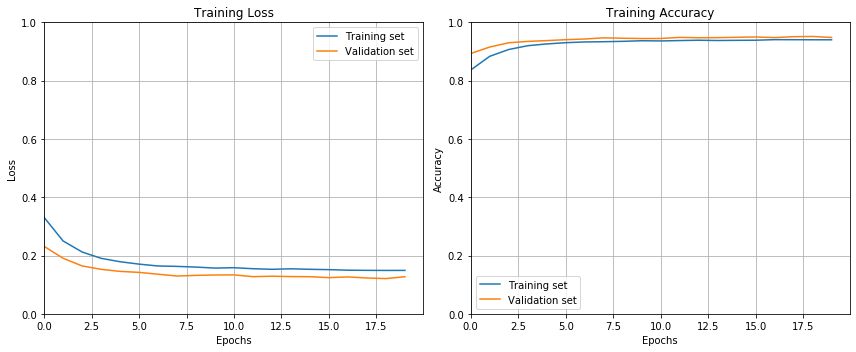

In [25]:
if train:
    # Plot Train History
    draw_train_history(hist);

In [ ]:
# ANNVisualizer
# from ann_visualizer.visualize import ann_viz
# ann_viz(model, view=True,  filename="dnn", title="Deep Neural Network")

if Train:
    # Fit the Model
    hist = model.fit_generator(generator=train_batcher, steps_per_epoch=epoch_size, epochs=num_epochs,
                               verbose=1, validation_data=valid_batcher, validation_steps=val_step, 
                               use_multiprocessing=False)

In [ ]:
if train:
    # Fit the Model
    hist = model.fit(X, y, epochs=20, batch_size=batch_size, validation_split=val_frac, verbose=1)

Train on 496944 samples, validate on 55216 samples
Epoch 1/20
496944/496944 [==============================] - 21s 43us/step - loss: 0.1088 - acc: 0.9440 - val_loss: 0.0877 - val_acc: 0.9522
Epoch 2/20
496944/496944 [==============================] - 21s 43us/step - loss: 0.1079 - acc: 0.9442 - val_loss: 0.0875 - val_acc: 0.9526
Epoch 3/20
496944/496944 [==============================] - 21s 43us/step - loss: 0.1076 - acc: 0.9442 - val_loss: 0.0862 - val_acc: 0.9531
Epoch 4/20
496944/496944 [==============================] - 22s 44us/step - loss: 0.1078 - acc: 0.9443 - val_loss: 0.0852 - val_acc: 0.9532
Epoch 5/20
496944/496944 [==============================] - 22s 45us/step - loss: 0.1068 - acc: 0.9446 - val_loss: 0.0852 - val_acc: 0.9543
Epoch 6/20
 56320/496944 [==>...........................] - ETA: 18s - loss: 0.1096 - acc: 0.9429

In [ ]:
if train:
    # Plot Train History
    draw_train_history(hist);

In [ ]:
if train:
    # Save the Model
    model.save('models/mymodel.h5')
    
    # Save History (Using Pickle)
    with open('models/mymodel.pickle', 'wb') as hist_file:
        pickle.dump(hist.history, hist_file)

## _Load Model_

In [ ]:
Load=True

In [ ]:
if Load:
    history = None
    with open('models/dnn_inout.pickle', 'rb') as pickle_in:
        history = pickle.load(pickle_in)
    draw_pickled_history(history, draw_val=True);

In [ ]:
# if Load:
    # model = load_model('models/init_model_dnn.h5')

## _Test Model_

*Accuracy/Classification:* `np.mean(y_pred == y_test)`
*Missclassification:* `np.mean(y_pred != y_test`

In [ ]:
# See Model Metrics
# model.metrics_names

In [ ]:
# test_set loss and accuracy
# test_loss, test_acc = model.evaluate(X_test, y_test)

In [ ]:
# Print test_set loss and accuracy
# print("test_loss:", test_loss, ", test_acc:", test_acc)

## _Model Predictions_

*Prediction:* `y_pred = model.predict(X_test)`

In [ ]:
# Get test set predictions
# y_pred = model.predict(X_test)
# y_pred.shape

## _SttHitClusterer_

In [ ]:
class SttHitClusterer:
    def __init__(self, path, model=None, batch_size=128, num_epochs=10):
        
        # Build Model:
        self.model = model
        # self.model = build_model(self.hidden_dim, DetectorGeometry.layer_r.shape[0], self.num_phi_bin)
        # self.model = init_model_dnn(shape=10)
        
        # Params:
        self.path = path
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.val_frac = 0.2

        # Params:
        self.train_input = None
        self.train_target = None
        self.test_input = None
        self.test_pred = None
        
        # Params:
        self.history = None
        self.prepared = False
    
    def prepare_data(self, events, n_events):
        if self.prepared:
            return
        self.prepared = True
        self.train_input, train_target = prepare_pairs(events=events, n_events=n_events)
        
    def fit(self, events, n_events):
        
        # Prepare Data
        prepare_data(self, events, n_events)
        
        # Fit DNN Model
        self.history = self.model.fit(x=self.train_input,
                                      y=self.train_target,
                                      batch_size=self.batch_size,
                                      epochs=self.num_epochs,
                                      validation_split=self.val_frac)
        # Save the Model
        self.model.save("model.h5")
        
    def predict_single_event(self, x_event):
        print("TODO: predict single event")
        
    def param_summary(self):
        print("batch_size:", self.batch_size)
        print("num_epochs:", self.num_epochs)
        print("val. fraction:", self.val_frac)

In [ ]:
clust = SttHitClusterer(path, model)

In [ ]:
clust.param_summary()